<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product ">
</a> 


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="200" alt="cognitiveclass.ai logo">


<h1><h1>Pre-trained-Models with PyTorch </h1>


In this lab, you will use pre-trained models to classify between the negative and positive samples; you will be provided with the dataset object. The particular pre-trained model will be resnet18; you will have three questions: 
<ul>
<li>change the output layer</li>
<li> train the model</li> 
<li>  identify  several  misclassified samples</li> 
 </ul>
You will take several screenshots of your work and share your notebook. 


<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">


<ul>
    <li><a href="#download_data"> Download Data</a></li>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
    <li><a href="#Question_1">Question 1</a></li>
    <li><a href="#Question_2">Question 2</a></li>
    <li><a href="#Question_3">Question 3</a></li>
</ul>
<p>Estimated Time Needed: <strong>120 min</strong></p>
 </div>
<hr>


<h2 id="download_data">Download Data</h2>


Download the dataset and unzip the files in your data directory, unlike the other labs, all the data will be deleted after you close  the lab, this may take some time:


In [1]:
#!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

In [2]:
#!unzip -qn Positive_tensors.zip 

In [3]:
#!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
#!unzip -qn Negative_tensors.zip

We will install torchvision:


In [4]:
#!pip install torchvision

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.


In [5]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [6]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


In [7]:
#Count the number of files unzipped
directory="./"
positive="Positive_tensors"
negative='Negative_tensors'
positive_file_path=os.path.join(directory,positive)
negative_file_path=os.path.join(directory,negative)
positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
number_of_samples=len(positive_files)+len(negative_files)
print(len(positive_files))
print(len(negative_files))

20000
20000


<h2 id="data_class">Dataset Class</h2>


 This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.


In [8]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self, transform=None, train=True):
        directory = "./"
        positive = "Positive_tensors"
        negative = 'Negative_tensors'

        positive_file_path = os.path.join(directory, positive)
        negative_file_path = os.path.join(directory, negative)

        # Initialize lists to hold valid files and their corresponding labels
        self.all_files = []
        self.Y = []

        # Function to check if a file can be loaded
        def is_loadable(file_path):
            return True    # assume all files can be loaded
#            try:
#                _ = torch.load(file_path)
#                return True
#            except Exception as e:
#                print(f"Error loading {file_path}: {e}. Skipping this file.")
#                return False

        # Load positive files
        positive_files = [os.path.join(positive_file_path, file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        count = 0
        for file in positive_files:
            if count % 500 == 0 and count >= 500:
                print(f"{count} positive files read.")
            if is_loadable(file):
                self.all_files.append(file)
                self.Y.append(1)  # Label for positive files
            count += 1
            
        # Load negative files
        negative_files = [os.path.join(negative_file_path, file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        count = 0
        for file in negative_files:
            if count % 500 == 0 and count >= 500:
                print(f"{count} negative files read.")
            if is_loadable(file):
                self.all_files.append(file)
                self.Y.append(0)  # Label for negative files
            count += 1
                
        # Convert the labels list to a LongTensor
        self.Y = torch.tensor(self.Y, dtype=torch.long)

        # Apply transform
        self.transform = transform
        
        # Subset the dataset for training or validation
        if train:
            self.all_files = self.all_files[:30000]
            self.Y = self.Y[:30000]
        else:
            self.all_files = self.all_files[30000:]
            self.Y = self.Y[30000:]

        # Set the length of the dataset
        self.len = len(self.all_files)

    def __getitem__(self, idx):
        image = torch.load(self.all_files[idx])
        y = self.Y[idx]

        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)
                
        return image, y

    def __len__(self):
        # Return the length of the dataset
        return len(self.all_files)
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.


In [9]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print(len(train_dataset))
print(len(validation_dataset))
print("done")

500 positive files read.
1000 positive files read.
1500 positive files read.
2000 positive files read.
2500 positive files read.
3000 positive files read.
3500 positive files read.
4000 positive files read.
4500 positive files read.
5000 positive files read.
5500 positive files read.
6000 positive files read.
6500 positive files read.
7000 positive files read.
7500 positive files read.
8000 positive files read.
8500 positive files read.
9000 positive files read.
9500 positive files read.
10000 positive files read.
10500 positive files read.
11000 positive files read.
11500 positive files read.
12000 positive files read.
12500 positive files read.
13000 positive files read.
13500 positive files read.
14000 positive files read.
14500 positive files read.
15000 positive files read.
15500 positive files read.
16000 positive files read.
16500 positive files read.
17000 positive files read.
17500 positive files read.
18000 positive files read.
18500 positive files read.
19000 positive files 

<h2 id="Question_1">Question 1</h2>


<b>Prepare a pre-trained resnet18 model :</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:


In [10]:
# Step 1: Load the pre-trained model resnet18

# Type your code here
model = models.resnet18(pretrained=True)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

#composed=transforms.Compose[transforms.Resize(224),transforms.ToTensor,transforms.Normalize(mean, std)])
#train_dataset=Dataset(transform=composed, train=True )
#validation_data=Dataset(transform=composed)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jupyterlab/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [11]:
# Step 2: Set the parameter cannot be trained for the pre-trained model

# Type your code here
for param in model.parameters():
    param.requires_grad=False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [12]:
model.fc=nn.Linear(512,7)

Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>


In [13]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2 id="Question_2">Question 2: Train the Model</h2>


In this question you will train your, model:


<b>Step 1</b>: Create a cross entropy criterion function 


In [14]:
# Step 1: Create the loss function

# Type your code here
criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.


In [15]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader=torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=100)
print("Number of training batches = ", len(train_loader))
print("Number of validation batches = ", len(validation_loader))

Number of training batches =  300
Number of validation batches =  100


<b>Step 3</b>: Use the following optimizer to minimize the loss 


In [16]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->


**Complete the following code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.**


In [17]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    batchnum = 0
    for x, y in train_loader:
        if x is None or y is None:
            continue  # Skip this batch
        if batchnum % 10 == 0:
            print(f"Working on training batch {batchnum} to {batchnum+9}...")
        model.train() 
        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        z = model(x)
        # calculate loss 
        loss = criterion(z, y)
        # calculate gradients of parameters
        loss.backward()
        # update parameters 
        optimizer.step()
        loss_list.append(loss.data)
        batchnum += 1

    correct=0
    batchnum=0
    for x_test, y_test in validation_loader:
        if x_test is None or y_test is None:
            continue  # Skip this batch
        if batchnum % 10 == 0:
            print(f"Working on validation batch {batchnum} to {batchnum+9}...")
        # set model to eval 
        model.eval()
        #make a prediction 
        z = model(x_test)
        #find max 
        _, yhat = torch.max(z.data, 1)    
        #Calculate misclassified  samples in mini-batch 
        #hint +=(yhat==y_test).sum().item()
        correct += (yhat == y_test).sum().item()
        batchnum += 1
   
    accuracy=correct/N_test
    accuracy_list.append(accuracy)


Working on training batch 0 to 9...
Working on training batch 10 to 19...
Working on training batch 20 to 29...
Working on training batch 30 to 39...
Working on training batch 40 to 49...
Working on training batch 50 to 59...
Working on training batch 60 to 69...
Working on training batch 70 to 79...
Working on training batch 80 to 89...
Working on training batch 90 to 99...
Working on training batch 100 to 109...
Working on training batch 110 to 119...
Working on training batch 120 to 129...
Working on training batch 130 to 139...
Working on training batch 140 to 149...
Working on training batch 150 to 159...
Working on training batch 160 to 169...
Working on training batch 170 to 179...
Working on training batch 180 to 189...
Working on training batch 190 to 199...
Working on training batch 200 to 209...
Working on training batch 210 to 219...
Working on training batch 220 to 229...
Working on training batch 230 to 239...
Working on training batch 240 to 249...
Working on training ba

<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>


In [18]:
accuracy

1.0

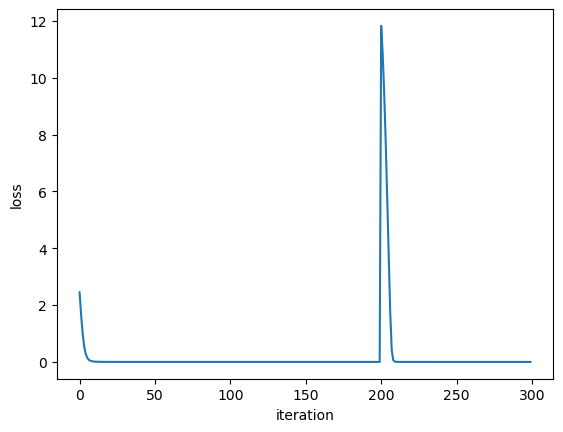

In [19]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


<h2 id="Question_3">Question 3:Find the misclassified samples</h2> 


<b>Identify the first four misclassified samples using the validation data:</b>


In [20]:
#define a function to display the tensor image
def display_tensor_image(tensor_img):
    if tensor_img.is_cuda:
        tensor_img = tensor_img.cpu()
    
    if tensor_img.dim() == 4:
        tensor_img = tensor_img.squeeze(0)

    if tensor_img.shape[0] == 3:
        tensor_img = tensor_img.permute(1, 2, 0)
    
    img_np = tensor_img.numpy()
    img_np = (img_np * 0.5) + 0.5
    img_np = np.clip(img_np, 0, 1)

    plt.imshow(img_np)
    plt.axis('off')
    plt.show()

In [ ]:
i = 1
for x_test, y_test in validation_loader:
    model.eval()
    with torch.no_grad():
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        for j in range(len(y_test)):
            if yhat[j] != y_test[j]:
                print(f"Misclassified {i}: predicted is {yhat[j].item()}, actual is {y_test[j].item()}")
                display_tensor_image(x_test[j])
                i += 1
                # max four misclassified samples
                if i > 4:
                    break

<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/share-notebooks.html?utm_source=Exinfluencer&utm_content=000026UJ&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01&utm_medium=Exinfluencer&utm_term=10006555"> CLICK HERE </a> Click here to see how to share your notebook.


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.



## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-21  | 2.0  | Shubham  |  Migrated Lab to Markdown and added to course repo in GitLab |



<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>


Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">MIT License</a>.
